# Libraries :

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from operator import itemgetter
import matplotlib.pyplot as plt
import collections
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman
import itertools
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing data Player summaries
users = pd.read_csv('data/Player_Summaries.csv')

# Extracting a subset of columns:
users = users[['steamid','personaname','lastlogoff','primaryclanid','timecreated','gameid','gameserverip','loccountrycode','locstatecode','loccityid','dateretrieved']]

# Checking the unicity of steam id:
users.steamid.is_unique

True

In [3]:
#Changing index to steamid
users.set_index('steamid', inplace=True)
users.head(5)

,personaname,lastlogoff,primaryclanid,timecreated,gameid,gameserverip,loccountrycode,locstatecode,loccityid,dateretrieved
steamid,,,,,,,,,,
76561198024350932,DGJarski,2011-12-07 02:31:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-08 01:48:13
76561197972375740,Kregger,2013-02-18 03:53:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-02-28 14:38:19
76561197972581736,3ulle+ C@+cher,2011-08-29 18:36:52,1.035828e+17,2004-12-29 09:00:06,NaN,NaN,NaN,NaN,NaN,2013-02-28 14:38:22
76561198027776732,ÐºÐ°Â®Ð»Â©Ð¾Ð½Â©,2010-11-23 08:13:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-08 14:45:09
76561198080962334,Djcs124,2013-03-14 16:37:21,1.035828e+17,2013-01-08 13:54:23,NaN,NaN,NaN,NaN,NaN,2013-03-14 23:02:27


In [4]:
## Information about the dataset
def info(df):
    print('The number of rows:', len(df))
    print('The number of columns:', len(df.columns))
    print('Columns name and type:')
    print(df.dtypes)
    print('Null values among the columns:')
    print(df.isnull().any())        

In [5]:
info(users)

The number of rows: 250000
The number of columns: 10
Columns name and type:
personaname        object
lastlogoff         object
primaryclanid     float64
timecreated        object
gameid            float64
gameserverip       object
loccountrycode     object
locstatecode       object
loccityid         float64
dateretrieved      object
dtype: object
Null values among the columns:
personaname        True
lastlogoff         True
primaryclanid      True
timecreated        True
gameid             True
gameserverip       True
loccountrycode     True
locstatecode       True
loccityid          True
dateretrieved     False
dtype: bool


### Building the network :
Our network will be generated from the dataset friends. The edges set of the graph $E(G)$ will be extracted from the columns `steamid_a`and `steamid_b`. To begin, we will inspect the number of nodes and the uniqueness of the two columns.

In [6]:
## Importing data : Friends
friends = pd.read_csv('data/Friends.csv' )
print('The number of unique elements in steamid_a',len(friends.steamid_a.unique()))
print('The number of unique elements in steamid_b',len(friends.steamid_b.unique()))
print('the number of shared elements between the two columns',len(np.where(friends.steamid_a.unique()==friends.steamid_b.unique())))
friends.head(5)

The number of unique elements in steamid_a 71091
The number of unique elements in steamid_b 760107
the number of shared elements between the two columns 1


,steamid_a,steamid_b,friend_since,dateretrieved
0,76561198081638400,76561198061647456,2013-02-22 05:24:36 UTC,2013-09-24 13:31:25 UTC
1,76561198081638400,76561198050245657,2013-01-23 13:04:35 UTC,2013-09-24 13:31:25 UTC
2,76561198001291264,76561198009238138,2009-12-07 09:55:10 UTC,2013-06-09 01:01:03 UTC
3,76561197989101568,76561198031884772,2012-05-06 13:18:45 UTC,2013-07-18 01:36:51 UTC
4,76561197989101568,76561198085268255,2013-10-11 14:05:12 UTC,2013-10-24 23:24:37 UTC


In [7]:
info(friends)

The number of rows: 805329
The number of columns: 4
Columns name and type:
steamid_a         int64
steamid_b         int64
friend_since     object
dateretrieved    object
dtype: object
Null values among the columns:
steamid_a        False
steamid_b        False
friend_since     False
dateretrieved    False
dtype: bool


Here we will built a friendship network : the nodes will be the users and the edges will be the friendship relation. The graph is undirected since the friendship relation is symetric.

## Graph discription :
Graph description will give us a summary about the network:

* The number of nodes 
* The number of edges 
* The average shortest path : the average subject to all possible pairs of nodes of the length of all shortest paths
* The connectivity of the graph
* Sparsity" of a graph with $n$ nodes is defined as follows: 
$ L = \frac{|E|}{|E_{max}|}$, where $E_{max} = \frac{n * (n-1)}{2}$
* The transitivity : global clustering coefficient or the ratio of all existing triangles (closed triples) over all possible triangles

In [8]:
def describe_graph(G):
    print(nx.info(G))
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) 
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

## Degree distribution :

In [9]:
def plot_degree_distribution(G,log=False):
    degrees = {}
    
    for node in G.nodes():
        degree = G.degree(node)
        
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    print('The maximum degree is',max(deg))
    print('The minimum degree is',min(deg))
  
    if log :
        fig, ax = plt.subplots(figsize=(20,5))
        plt.bar(deg, np.log(cnt),alpha=0.7, width=0.80, color='b')
        plt.title("Degree Distribution")
        plt.ylabel("log(Frequency)")
        plt.xlabel("Degree")
        ax.set_xticks([d+0.05 for d in deg])
        ax.set_xticklabels(deg)
    else:
        fig, ax = plt.subplots()
        plt.bar(deg, cnt, width=0.80, color='b')
        plt.title("Degree Distribution")
        plt.ylabel("Frequency")
        plt.xlabel("Degree")
        ax.set_xticks([d+0.05 for d in deg])
        ax.set_xticklabels(deg)
    

In [10]:
userG = nx.from_pandas_edgelist(friends, 'steamid_a', 'steamid_b', edge_attr=None, create_using= nx.Graph())
describe_graph(userG)

Name: 
Type: Graph
Number of nodes: 829208
Number of edges: 804259
Average degree:   1.9398
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0000
Global clustering coefficient aka Transitivity: 0.0006


#### Comments on the graph:
So as you can see the number of edges in the graph is less than the number of nodes which explains the null value of the sparcity. The transitivity is low, which is something that we have to consider, since a "friend of my friend could be my friend". The average degree in the graph is 1.93 which means that on average each player has two friends.

#### Adding an attribute to the nodes:

In the users dataset we have only access to the informations of 250000 gamer. so we can try to add attributes to the nodes of the network:

In [11]:
## Adding attributes to the nodes from the user dataset:
nx.set_node_attributes(userG, users['personaname'].to_dict(), 'personaname' )
## Verifying :
userG.node[76561197972906276]

{'personaname': 'slav3'}

### Analyzing the degree distribution:

The $log(frequency)$ of degrees follows a power low.

The maximum degree is 350
The minimum degree is 1


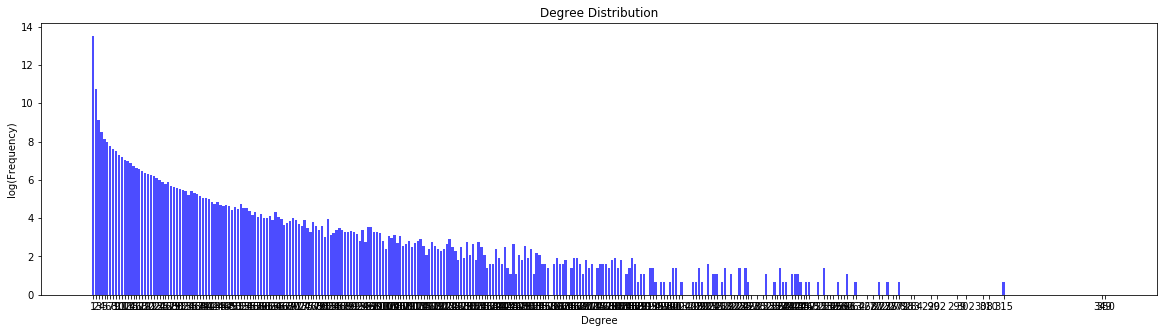

In [12]:
plot_degree_distribution(userG, True)

## Analysis of importance :
Imagine if we are game developpers and we are intersted to run adds for our new game. Nowadays, adds are expensive so we have to find a way to pay less and to get more 'impactful' views. Like Cambridge Analytica, we will try to use targeted adds (Without stealing data :) ). Network analysis, is a good way to analyse social importance via different metrics. In our case the degree forms a good metric once combined with the transitivity. So if we target the important nodes, we will impact on their neighbors. The degree is not always a good metric, on Twitter some scam accounts are followed by 100000 scam account. There are several metrics to detect important nodes :

* Betweeness centrality $C(i)$ : the fraction of all shortest paths in the network that pass through node i (Expensive to compute in our case).

* Katz centrality : it's a generalisation of the degree metric. $C(i)$: number of paths from other nodes to i, giving less weight to larger distances (Expensive to compute in our case).


### Top_10 important gamers, based on the degree:

In [13]:
## Important gamers in terms of friendship degree:
Top_10 = sorted(userG.degree, key=lambda x: x[1], reverse=True)[:10]

for (v,d) in Top_10:
    print('The player',users.loc[v].at['personaname'],'having the steamid ',v,' has ',d ,'friend')

The player CreatorZombie having the steamid  76561198080816434  has  350 friend
The player 7Focus. 20731 [beaab]  â™¥ having the steamid  76561198074142646  has  349 friend
The player complicated having the steamid  76561198000876540  has  315 friend
The player =PB R= Medicinal Mushroomfusion having the steamid  76561198029344438  has  315 friend
The player _JoSe STREAMLINE having the steamid  76561197972849898  has  310 friend
The player Agoat having the steamid  76561197988440812  has  308 friend
The player ivnliem having the steamid  76561198086201489  has  302 friend
The player *Ù­à¹–Û£ÌƒÛœâ‚©Ä„Í¡â‚®Â¥Ù­* having the steamid  76561197988855674  has  299 friend
The player _Ð™Ð°'GOOD'ÐºÐ°_ having the steamid  76561197988419014  has  292 friend
The player slav3 having the steamid  76561197972906276  has  290 friend


### Visualizing the graph : 
In this part we will try to visualize the subgraph of `CreatorZombie`and his neighbors. to see the repartition of the edges. 

In [14]:
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='b', node_shape=node_shape)
    plt.axis('off')

In [15]:
# Lets check by looking at the subgraph induced by "CreatorZombie"
subgraph_CZ = userG.subgraph([76561198080816434]+list(userG.neighbors(76561198080816434)))


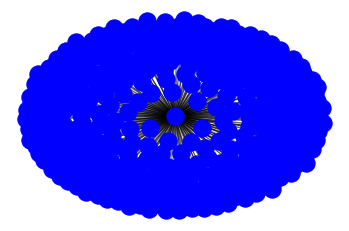

In [16]:
visualize_graph(subgraph_CZ, False, alpha=0.5)

In [17]:
describe_graph(subgraph_CZ)

Name: 
Type: Graph
Number of nodes: 351
Number of edges: 350
Average degree:   1.9943
Avg. Shortest Path Length: 1.9943
Diameter: 2.0000
Sparsity: 0.0057
Global clustering coefficient aka Transitivity: 0.0000


### Comments:

The graph and the describtion proves the importance of player 'CreatorZombie'. All the neighbors of `creatorzombie`does not share an edge, $Transitivity$=0. We see from the figure the centrality of the player and the Star shape of the graph.

If we consider a player with a median degree and inspect its graph:

In [18]:
### Order statistic gives us the quantile (the user) given a probability p and subject to the degree distribution:
def order_statistic(k):
    Sorted_degrees = sorted(userG.degree, key=lambda x: x[1], reverse=False)
    n = len(Sorted_degrees)
    return Sorted_degrees[int(k*n)-1]

In [19]:
order_statistic(0.5)

(76561198085420672, 1)

The median degree is 1, we can check the 3rd quartile:

In [20]:
## Q3 :
order_statistic(0.75)

(76561197973916491, 1)

The 3rd quartile has also degree 1, So we can check the 0.99 empiric quantile:

In [21]:
## 0.99 empiric quantile of the degree distribution :
order_statistic(0.99)

(76561198027871932, 24)

Name: 
Type: Graph
Number of nodes: 107
Number of edges: 106
Average degree:   1.9813
Avg. Shortest Path Length: 1.9813
Diameter: 2.0000
Sparsity: 0.0187
Global clustering coefficient aka Transitivity: 0.0000


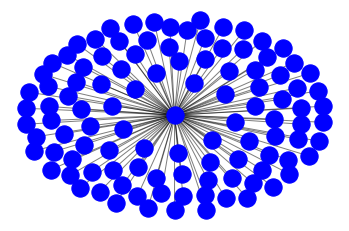

In [22]:
subgraph_99 = userG.subgraph([76561198079131308]+list(userG.neighbors(76561198079131308)))
describe_graph(subgraph_99)
visualize_graph(subgraph_99, False, alpha=0.5)

Our network is more or less a union of star shaped networks where we can find the nodes of steam_a column in the middle and the nodes of steamid_b connected to them. Since the transitivity of the whole graph is not zero so there are some star shaped subgraphs which are connected. The next step will be the inspection of the connected components.

## Connected Components :
The analysis of connected component is a sort of clustering based on a relation. The items belonging to the same component share the same behavior giving a relation. 

In [23]:
## the list and the number of connected components:
comp = list(nx.connected_components(userG))
print('The graph contains', len(comp), 'connected components')

The graph contains 50165 connected components


In [24]:
## Maximum size connencted component :
largest_comp = max(comp, key=len)
percentage_lcc = len(largest_comp)/userG.number_of_nodes() * 100
print('The largest component has', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes') 

The largest component has 538869 nodes accounting for 64.99 % of the nodes


In [25]:
### The giant Component
Gcc = sorted(comp, key=len, reverse=True)
GC = userG.subgraph(Gcc[0])
print(nx.info(GC))
##Sparsity:
print('The sparsity',nx.density(GC))
## Transitivity:
print('The Global clustering coefficient aka Transitivity',nx.transitivity(GC))

Name: 
Type: Graph
Number of nodes: 538869
Number of edges: 563224
Average degree:   2.0904
The sparsity 3.879230213849518e-06
The Global clustering coefficient aka Transitivity 0.0005474085027344604


In the giant componnent we have more edges than nodes. The transitivity is not equal to zero. Further, we can inspect the distribution of the size of different gaming communities. It is important to study this aspect because it we can understand the homophily within the group: “Birds of a feather flock together”.

In [26]:
size_components = list(map(lambda x : len(x),Gcc))

Text(0.5, 0, 'Components')

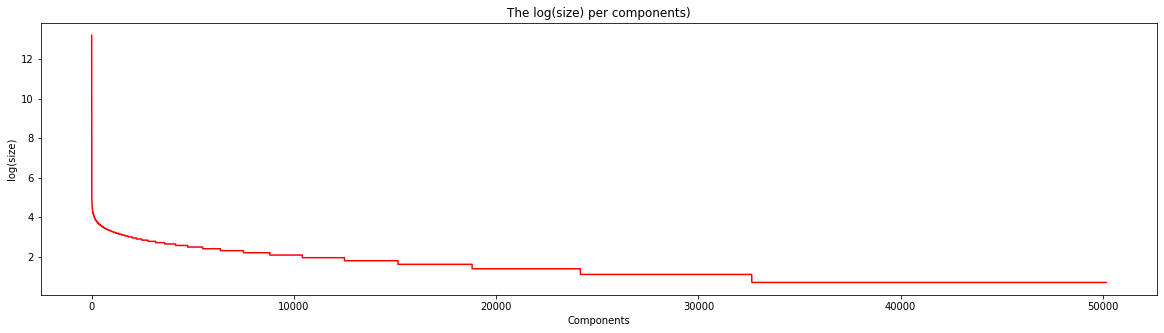

In [27]:
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(np.log(size_components), color='r')
plt.title("The log(size) per components)")
plt.ylabel("log(size)")
plt.xlabel("Components")

The communities in gaming are very diverse: we have giant communities with more than 500000 members and we have small ones with 100 members. However, you can see from the plot that the majority of the communities have a $log(size)$ less or equal to 4.

## Users and groups :
In the datasets we have groups, which consiste of users and groupes where they belong. we wanted to inspect if the friendship connections and the connected componnents that we have found in the previous section matches those groups. 
We will try to investigate the number of groups in the dataframe and compare the repartion of members subject to the group with the repartition in the connected components. This comparision will allow us to see if the friendships are made within the groups. 

In [28]:
## Reading groups dataset:
Groups = pd.read_csv('data/groups.csv')
Groups.head()

,steamid,groupid,dateretrieved
0,76561198079301664,2787047,2013-10-03 11:58:56 UTC
1,76561198079301664,5358,2013-10-03 11:58:56 UTC
2,76561198079301664,440319,2013-10-03 11:58:56 UTC
3,76561197974107716,36457,2013-05-14 14:02:40 UTC
4,76561197974107716,1835884,2013-05-14 14:02:40 UTC


In [29]:
info(Groups)

The number of rows: 144751
The number of columns: 3
Columns name and type:
steamid           int64
groupid           int64
dateretrieved    object
dtype: object
Null values among the columns:
steamid          False
groupid          False
dateretrieved    False
dtype: bool


In [30]:
## grouping subject to the groups
Groups = Groups.groupby('groupid').count()

In [31]:
## Getting the number of members within each group and sort it
sorted_sizes = sorted((Groups['steamid']), reverse = True )

In [32]:
info(Groups)

The number of rows: 59658
The number of columns: 2
Columns name and type:
steamid          int64
dateretrieved    int64
dtype: object
Null values among the columns:
steamid          False
dateretrieved    False
dtype: bool


Text(0.5, 0, 'Groups')

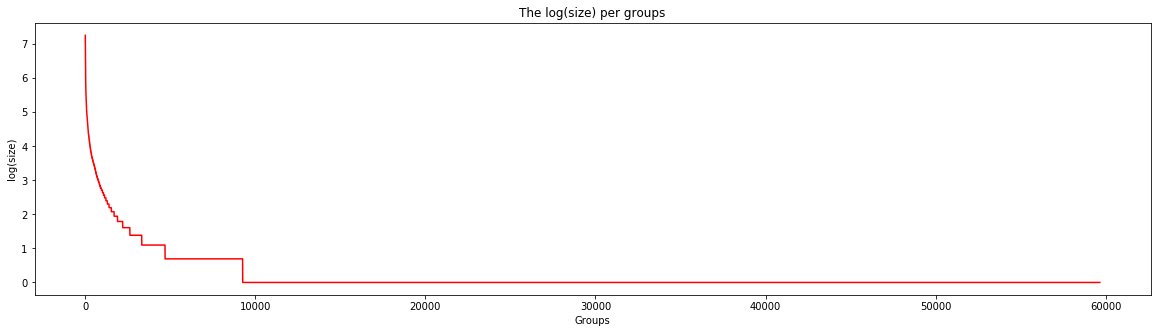

In [33]:
## Plotting the repartion of the number of members within the groups
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(np.log(sorted_sizes), color='r')
plt.title("The log(size) per groups")
plt.ylabel("log(size)")
plt.xlabel("Groups")

## Groups vs connected components:
So we have in total 59658 groups against 50165 components. So in total we have around 9500 additional group in the gamining community compared to the component. This make sense since each gamer represents a node in the network that we have built so he belongs to a unique connencted component. In the other hand, a gamer can belong to different groups (the first two rows of the Groups dataframe above).  The distribution of the size within groups, shows the same shape as the one within the components. 